# Overview
A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. 

The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI).

A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.

Application of automated classification techniques using Machine Learning(ML) and Artificial Intelligence(AI)has consistently shown higher accuracy than manual classification. Hence, proposing a system performing detection and classification by using Deep Learning Algorithms using ConvolutionNeural Network (CNN), Artificial Neural Network (ANN), and TransferLearning (TL) would be helpful to doctors all around the world.

# Context
Brain Tumors are complex. There are a lot of abnormalities in the sizes and location of the brain tumor(s). This makes it really difficult for complete understanding of the nature of the tumor.

Also, a professional Neurosurgeon is required for MRI analysis. Often times in developing countries the lack of skillful doctors and lack of knowledge about tumors makes it really challenging and time-consuming to generate reports from MRI’. So an automated system on Cloud can solve this problem.

# Problem Definition
A machine learning model to help identify brain tumor. This model will be apple to predict if a person has a brain tumor and the solutions needed to be taken.

# Dataset
The dataset can be located at kaggle. Click on the link to be directed to the datasets repository. [Link to datasets](https://www.kaggle.com/ahmedhamada0/brain-tumor-detection)

# Deployment
A restfull API will be created for the model and deployed on Google Cloud taking advantage of its serverless container engine(Cloudrun) All using automation script.

* Deployment Services
  * Python(FastAPI)
  * Cloudrun
  * Container Registory
  * Storage Bucket

* Others
  * Docker
  * gcloud
  * gsutil


# Get our tools and datasets ready
Okay so we are going to start to build our model. We will first import all the neccessary libries needed to build our model then download our datasets from a public storage repository from Google Cloud. Okay so lets get started.

In [1]:
#Import core tools
import matplotlib.image as plt_img
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#Import tensorflow libries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import normalize
import tensorflow as tf

#Import other libries
from sklearn.model_selection import train_test_split
from PIL import Image
import zipfile
import random
import cv2
import os

In [2]:
#Import datasets from Google Storage Bucket
!wget https://storage.googleapis.com/machine-learning-repository-fastbidgh-dev/brain_tumor_yes_no.zip
tumor = zipfile.ZipFile("brain_tumor_yes_no.zip")
tumor.extractall()
tumor.close()

--2021-10-14 08:57:43--  https://storage.googleapis.com/machine-learning-repository-fastbidgh-dev/brain_tumor_yes_no.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.181.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88397278 (84M) [application/zip]
Saving to: ‘brain_tumor_yes_no.zip’

brain_tumor_yes_no. 100%[===================>]  84.30M   104MB/s    in 0.8s    

2021-10-14 08:57:44 (104 MB/s) - ‘brain_tumor_yes_no.zip’ saved [88397278/88397278]



# Explore dataset
We have successfully been able to load in our dataset from Google Cloud Storage Bucket. Now, lets try to explore this dataset to no the total number of samples in each class and also to view image datasets from each class. Okay so lets get started.

In [3]:
#Check total number of dataset samples in training dataset
for dirpath, dirnames, filenames in os.walk("brain_tumor_yes_no/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 4 directories and 0 images in brain_tumor_yes_no/
There are 0 directories and 1500 images in brain_tumor_yes_no/yes
There are 3 directories and 1 images in brain_tumor_yes_no/Br35H-Mask-RCNN
There are 0 directories and 101 images in brain_tumor_yes_no/Br35H-Mask-RCNN/TEST
There are 0 directories and 202 images in brain_tumor_yes_no/Br35H-Mask-RCNN/VAL
There are 0 directories and 501 images in brain_tumor_yes_no/Br35H-Mask-RCNN/TRAIN
There are 0 directories and 60 images in brain_tumor_yes_no/pred
There are 0 directories and 1500 images in brain_tumor_yes_no/no


Okay so we can see the total number of datasets in each class. Now, we are going to create a custom function to help us visualize our datasets from each classes. Okay so lets get started.

In [4]:
#Custom function to help us visualize our datasets
def displayImages(target_folder, target_class):
  """
  This function will be used to
  visualize our datasets.
  Args: 
    target_folder = path to datasets
    target_class = class of dataset
  """
  #Set image path
  img_path = target_folder+target_class

  #Set random image path
  rand_image = random.sample(os.listdir(img_path), 1)

  #Read and plot image datasets
  img = plt_img.imread(img_path+"/"+rand_image[0])

  #Plot images
  plt.imshow(img)
  plt.title(target_class)
  plt.axis(False)

  return img

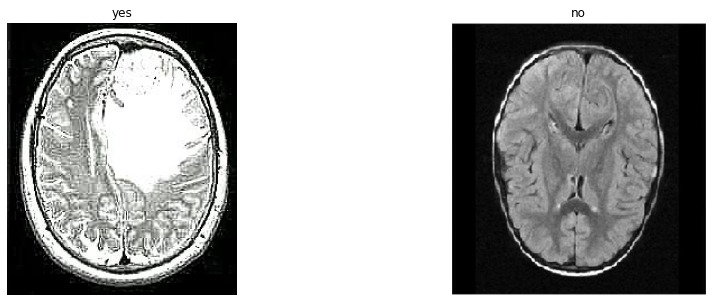

In [5]:
#Okay so now lets display our images
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
meningioma_tumor = displayImages("brain_tumor_yes_no/", "yes")
plt.subplot(1, 2, 2)
pituitary_tumor = displayImages("brain_tumor_yes_no/", "no")

# Preprocess Datasets

Okay so we have successfully visualize our datasets from both classess. The given dataset were not splited into training and test datasets. Hence we have to split the dataset into training and test datasets. But before we do that, we first have to preprocess our image into numeric(array format). Okay so now lets get started by preprocess our dataset now.

In [6]:
#Set random seed
tf.random.set_seed(42)

#Set images directories
image_dir = "/content/brain_tumor_yes_no/"

#Split dataset into tumor and no tumor datasets
no_tumor = os.listdir(image_dir+"no/")
yes_tumor = os.listdir(image_dir+"yes/")

#Define a variable for labels
label = []

#Define variable for actual datasets
dataset = []

#Preprocess No Tumor Images and append it to datasets variables
for i, image_name in enumerate(no_tumor):
  if image_name.split(".")[1] == "png" or image_name.split(".")[1] == "jpeg" or image_name.split(".")[1] == "jpg":
    image=cv2.imread(image_dir+"no/"+image_name)
    image=Image.fromarray(image, "RGB")
    image=image.resize((64, 64))
    dataset.append(np.array(image))
    label.append(0)

#Preprocess No Tumor Images and append it to datasets variables
for i, image_name in enumerate(yes_tumor):
  if image_name.split(".")[1] == "png" or image_name.split(".")[1] == "jpeg" or image_name.split(".")[1] == "jpg":
    image=cv2.imread(image_dir+"yes/"+image_name)
    image=Image.fromarray(image, "RGB")
    image=image.resize((64, 64))
    dataset.append(np.array(image))
    label.append(1)

In [7]:
#Check length of label and datasets
print(f"Length of dataset is {len(dataset)}")
print(f"Length of label is {len(label)}")

Length of dataset is 3000
Length of label is 3000


In [8]:
#Convert results into numpy array
dataset=np.array(dataset)
label=np.array(label)

In [9]:
#Now check both labels and datasets shapes
dataset.shape, label.shape

((3000, 64, 64, 3), (3000,))

Okay so we have successfully preproccessed our images into numpy arrays. Now we are going to split it into training and test datasets using **train_test_split** before we start building our model. Okay so lets get started now.

In [10]:
#Split datasets into training and test datasets
x_train, x_test, y_train, y_test = train_test_split(
    dataset,
    label, 
    test_size=0.2,
    random_state=42
)

In [11]:
#Okay so now lets check theri shapes
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2400, 64, 64, 3), (2400,), (600, 64, 64, 3), (600,))

Okay so we have successfully been able to split our datasets into train and testing. Now we are going to normalize our dataset and start building our models. We will start by creating a base model and try to beat this base model. Okay so lets get started now.

## model_0
Build base model using keras functional API

In [12]:
#set random seed
tf.random.set_seed(42)

#Normalize x_train and x_test datasets
x_train = x_train/.255
x_test = x_test/.255

#Define variables
INPUT_SHAPE=3

#Define input
inputs = tf.keras.layers.Input(shape=(64, 64, 3))

#Build models
x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=10,
    strides=1
)(inputs)

x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=10,
    strides=1
)(x)

x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=10,
    strides=1
)(x)

#Flattern model
x = tf.keras.layers.Flatten()(x)

#Define output
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

#Define model
model_0 = tf.keras.Model(inputs, outputs)

In [13]:
#Check model layers
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 32)        9632      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        102432    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 32)        102432    
_________________________________________________________________
flatten (Flatten)            (None, 43808)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 43809     
Total params: 258,305
Trainable params: 258,305
Non-trainable params: 0
_______________________________________________________

In [14]:
#Compile model
model_0.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [15]:
#set random seed
tf.random.set_seed(42)

#Fit model
history_0 = model_0.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10
)

Epoch 1/10
75/75 [==============================] - 32s 26ms/step - loss: 1684.9905 - accuracy: 0.6196 - val_loss: 40.0950 - val_accuracy: 0.7117
Epoch 2/10
75/75 [==============================] - 2s 21ms/step - loss: 12.1558 - accuracy: 0.8238 - val_loss: 5.5236 - val_accuracy: 0.8667
Epoch 3/10
75/75 [==============================] - 2s 21ms/step - loss: 3.0629 - accuracy: 0.9087 - val_loss: 3.9284 - val_accuracy: 0.9167
Epoch 4/10
75/75 [==============================] - 2s 21ms/step - loss: 1.9689 - accuracy: 0.9317 - val_loss: 5.7107 - val_accuracy: 0.8667
Epoch 5/10
75/75 [==============================] - 2s 21ms/step - loss: 1.3625 - accuracy: 0.9467 - val_loss: 3.9090 - val_accuracy: 0.9150
Epoch 6/10
75/75 [==============================] - 2s 21ms/step - loss: 0.8439 - accuracy: 0.9588 - val_loss: 3.6114 - val_accuracy: 0.9167
Epoch 7/10
75/75 [==============================] - 2s 21ms/step - loss: 0.6644 - accuracy: 0.9629 - val_loss: 3.4554 - val_accuracy: 0.9300
Epoch 8

In [16]:
#Evaluate our model
loss_0, accuracy_0 = model_0.evaluate(x_test, y_test)
loss_0, accuracy_0

19/19 [==============================] - 0s 7ms/step - loss: 3.2474 - accuracy: 0.9467


(3.247375249862671, 0.9466666579246521)

In [17]:
#A custom function to evaluate our model on loss and accuracy against epoch
def evaluate_model(history):
  """
  This function will be used
  to evaluate our models loss
  and accuracy against epochs.
  Args:
    history: Generated after
             model successfully
             been built.
  """
  #Get loss values
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  #Get acuracy values
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  #Get epoch value
  epoch = range(len(history.history["loss"]))
  plt.figure(figsize=(15, 5))

  #Plot accuracy against epoch
  plt.subplot(1, 2, 1)
  plt.plot(accuracy, epoch, label="accuracy")
  plt.plot(val_accuracy, epoch, label="val_accuracy")
  plt.xlabel("numbe of epochs")
  plt.ylabel("accuracy")
  plt.title("Accuracy against epoch")
  plt.legend()

  #Plot accuracy against epoch
  plt.subplot(1, 2, 2)
  plt.plot(accuracy, epoch, label="loss")
  plt.plot(val_accuracy, epoch, label="val_loss")
  plt.xlabel("numbe of epochs")
  plt.ylabel("loss")
  plt.title("Loss against epoch")
  plt.legend()

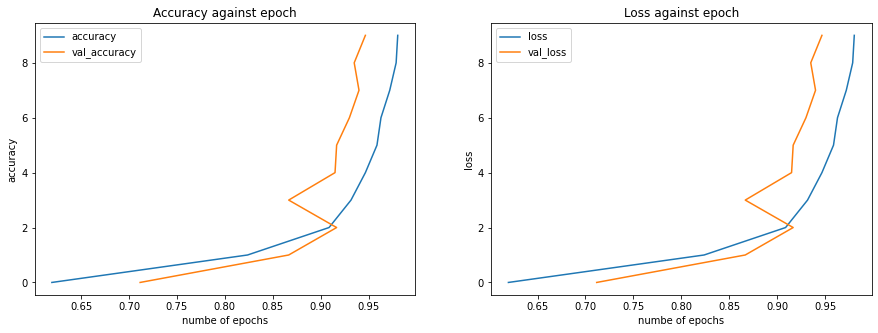

In [18]:
#Evaluate model
evaluate_model(history_0)

Okay so our model is doing well on training dataset but not on our test datasets. This means that our model is totally overfiting. Okay so now that we have our baseline defined, we are going to build more models to see if we will be able to beat our base model. Okay so lets get started now to build our first model.

## model_1
With this model, we are going to introduct `max polling layers` in our base model hoping to get a better results than our base model. Okay so lets get started now.

In [19]:
#set random seed
tf.random.set_seed(42)

#Define input shape
INPUT_SHAPE=(64, 64, 3)

#Define input layer
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

#Define layers
x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=10,
    strides=1,
    padding="same"
)(inputs)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

#Define output layer
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

#Define model
model_1 = tf.keras.Model(inputs, outputs)

In [20]:
#Check model layers
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9632      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        102432    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        102432    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0   

In [21]:
#Compile models
model_1.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [22]:
#Set random seed
tf.random.set_seed(42)

#Fit on train datasets
history_1 = model_1.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=15
)

Epoch 1/15
75/75 [==============================] - 3s 24ms/step - loss: 99.1262 - accuracy: 0.5738 - val_loss: 4.0728 - val_accuracy: 0.6800
Epoch 2/15
75/75 [==============================] - 2s 21ms/step - loss: 1.4805 - accuracy: 0.7892 - val_loss: 1.0100 - val_accuracy: 0.7650
Epoch 3/15
75/75 [==============================] - 2s 21ms/step - loss: 0.3646 - accuracy: 0.8950 - val_loss: 0.4462 - val_accuracy: 0.8467
Epoch 4/15
75/75 [==============================] - 2s 21ms/step - loss: 0.3510 - accuracy: 0.8963 - val_loss: 0.1633 - val_accuracy: 0.9400
Epoch 5/15
75/75 [==============================] - 2s 20ms/step - loss: 0.0749 - accuracy: 0.9771 - val_loss: 0.1403 - val_accuracy: 0.9667
Epoch 6/15
75/75 [==============================] - 2s 21ms/step - loss: 0.0714 - accuracy: 0.9746 - val_loss: 0.1606 - val_accuracy: 0.9500
Epoch 7/15
75/75 [==============================] - 2s 21ms/step - loss: 0.0411 - accuracy: 0.9892 - val_loss: 0.1560 - val_accuracy: 0.9617
Epoch 8/15
7

In [23]:
#Evaluate model
loss_1, accuracy_1 = model_1.evaluate(x_test, y_test)
loss_1, accuracy_1

19/19 [==============================] - 0s 12ms/step - loss: 0.0963 - accuracy: 0.9750


(0.09632334113121033, 0.9750000238418579)

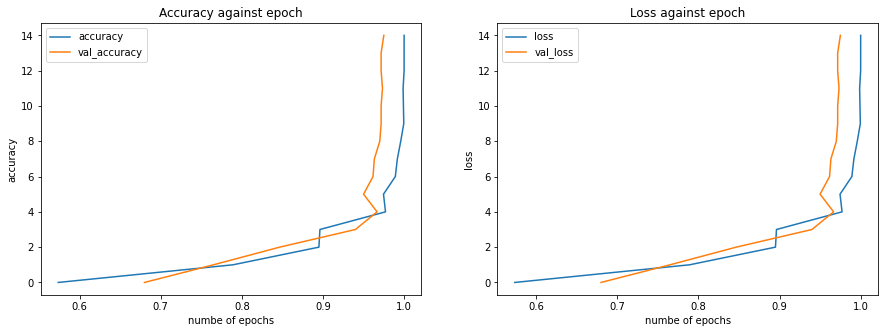

In [24]:
#Evaluate accuracy and loss against epoch
evaluate_model(history_1)

## model_2
Okay so we are going to build our 3rd model. With this model, we are going to add two more layers to above layers making 5 conv2D layer and also increase the total number of layers. Okay so lets get started now. 

In [25]:
#Set random seed
tf.random.set_seed(42)

#Define input layer
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

#Define layers
x = tf.keras.layers.Conv2D(
    filters=100,
    kernel_size=3,
    strides=1,
    padding="same"
)(inputs)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=100,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=100,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=100,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=100,
    kernel_size=10,
    strides=1,
    padding="same"
)(x)

# Add Global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#Add output layer
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

#Add model layer
model_2 = tf.keras.Model(inputs, outputs)

In [26]:
#Check models layer
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 100)       2800      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 100)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 100)       1000100   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 100)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 100)       1000100   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 100)         0   

In [27]:
#Compile model
model_2.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [28]:
#Set random seed
tf.random.set_seed(42)

#Fit on train datasets
history_2 = model_2.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20
)

Epoch 1/20
75/75 [==============================] - 8s 82ms/step - loss: 10411.3096 - accuracy: 0.5437 - val_loss: 49.3366 - val_accuracy: 0.6083
Epoch 2/20
75/75 [==============================] - 5s 70ms/step - loss: 23.6307 - accuracy: 0.6746 - val_loss: 5.1042 - val_accuracy: 0.7200
Epoch 3/20
75/75 [==============================] - 5s 70ms/step - loss: 4.3455 - accuracy: 0.7646 - val_loss: 2.8736 - val_accuracy: 0.7600
Epoch 4/20
75/75 [==============================] - 5s 69ms/step - loss: 3.1852 - accuracy: 0.7475 - val_loss: 1.2985 - val_accuracy: 0.8117
Epoch 5/20
75/75 [==============================] - 5s 71ms/step - loss: 1.6507 - accuracy: 0.8104 - val_loss: 1.9636 - val_accuracy: 0.7583
Epoch 6/20
75/75 [==============================] - 5s 70ms/step - loss: 0.6170 - accuracy: 0.8754 - val_loss: 0.5450 - val_accuracy: 0.8567
Epoch 7/20
75/75 [==============================] - 5s 71ms/step - loss: 0.2947 - accuracy: 0.9258 - val_loss: 1.3175 - val_accuracy: 0.8200
Epoch 8

In [29]:
#Evaluate model
loss_2, accuracy_2 = model_2.evaluate(x_test, y_test)
loss_2, accuracy_2

19/19 [==============================] - 0s 22ms/step - loss: 0.1286 - accuracy: 0.9617


(0.12864413857460022, 0.9616666436195374)

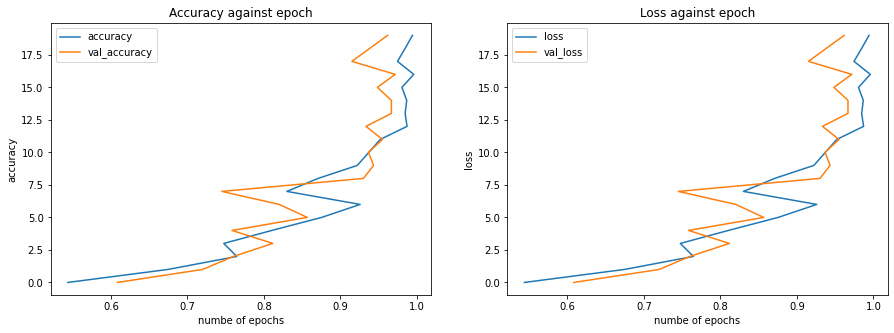

In [30]:
#Evaluate accuracy and loss against epoch
evaluate_model(history_2)

## model_3
Okay so from above, we can see that our model is doing well. But we have to try to reduce the loss value. With the 3rd model that we are going to create, we are going to clone `model_2` and increase the total number of epochs from 15 to 30.

In [31]:
#Set random seed
tf.random.set_seed(42)

#Clone model_2 as model_3
model_3 = tf.keras.models.clone_model(model_2)

#Compile model_3
model_3.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [32]:
#set random seed
tf.random.set_seed(42)

#Fit on train datasets
history_3 = model_3.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=30
)

Epoch 1/30
75/75 [==============================] - 6s 73ms/step - loss: 10411.4053 - accuracy: 0.5437 - val_loss: 49.4669 - val_accuracy: 0.6133
Epoch 2/30
75/75 [==============================] - 5s 71ms/step - loss: 19.9254 - accuracy: 0.6883 - val_loss: 4.2622 - val_accuracy: 0.7583
Epoch 3/30
75/75 [==============================] - 5s 71ms/step - loss: 5.8484 - accuracy: 0.7296 - val_loss: 3.5564 - val_accuracy: 0.7317
Epoch 4/30
75/75 [==============================] - 5s 71ms/step - loss: 2.4558 - accuracy: 0.7808 - val_loss: 3.2467 - val_accuracy: 0.7367
Epoch 5/30
75/75 [==============================] - 5s 70ms/step - loss: 1.3850 - accuracy: 0.8158 - val_loss: 1.0833 - val_accuracy: 0.8633
Epoch 6/30
75/75 [==============================] - 5s 71ms/step - loss: 0.6155 - accuracy: 0.8796 - val_loss: 0.3961 - val_accuracy: 0.8900
Epoch 7/30
75/75 [==============================] - 5s 71ms/step - loss: 0.3790 - accuracy: 0.9117 - val_loss: 0.3235 - val_accuracy: 0.9067
Epoch 8

In [33]:
#Evaluate our model
loss_3, accuracy_3 = model_3.evaluate(x_test, y_test)
loss_3, accuracy_3

19/19 [==============================] - 1s 28ms/step - loss: 0.0977 - accuracy: 0.9700


(0.09774110466241837, 0.9700000286102295)

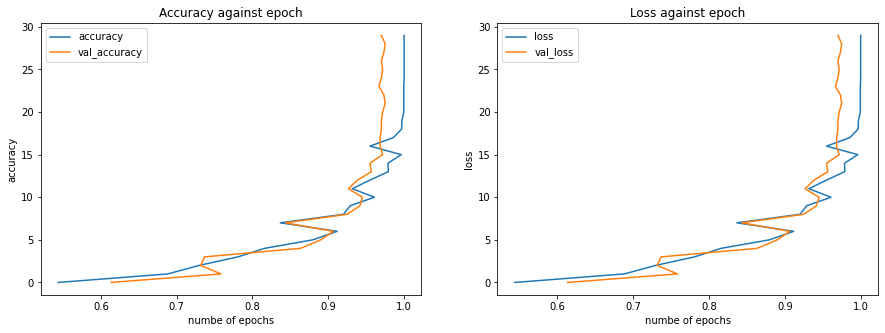

In [34]:
#Evaluate accuracy and loss against epochs
evaluate_model(history_3)

Okay so we can see that our model is performing well more than the previous model but we still have to find a way to reduce our loss values. Okay so now lets continue to by building our 4th model hoping to get a better results.

## model_5
We are going to build our 5th model. With this model, we are going to buid add the following layers to our model.

* BatchNormalization
* Droupout
* GlobalAveragePooling
* Decreare the total number of filters coming down

In [35]:
#Set random seed
tf.random.set_seed(42)

#Define input layer
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

#Define layers
x = tf.keras.layers.Conv2D(
    filters=100,
    kernel_size=3,
    strides=1,
    padding="same"
)(inputs)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=16,
    kernel_size=3,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(
    filters=8,
    kernel_size=3,
    strides=1,
    padding="same"
)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

#Global Average Pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#Define outputs
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

#Define model
model_5 = tf.keras.Model(inputs, outputs)

In [36]:
#Check models layer
model_5.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 100)       2800      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 100)       400       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 100)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        57664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0   

In [37]:
#Compile model
model_5.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [38]:
#Fit on traing datasets
history_5 = model_5.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10
)

Epoch 1/10
75/75 [==============================] - 4s 30ms/step - loss: 0.4444 - accuracy: 0.7904 - val_loss: 1.1380 - val_accuracy: 0.6233
Epoch 2/10
75/75 [==============================] - 2s 26ms/step - loss: 0.2824 - accuracy: 0.9013 - val_loss: 0.6562 - val_accuracy: 0.7067
Epoch 3/10
75/75 [==============================] - 2s 26ms/step - loss: 0.1797 - accuracy: 0.9588 - val_loss: 0.2555 - val_accuracy: 0.8967
Epoch 4/10
75/75 [==============================] - 2s 26ms/step - loss: 0.1191 - accuracy: 0.9754 - val_loss: 0.1344 - val_accuracy: 0.9550
Epoch 5/10
75/75 [==============================] - 2s 27ms/step - loss: 0.0653 - accuracy: 0.9912 - val_loss: 0.2675 - val_accuracy: 0.8733
Epoch 6/10
75/75 [==============================] - 2s 26ms/step - loss: 0.0519 - accuracy: 0.9929 - val_loss: 0.3077 - val_accuracy: 0.8867
Epoch 7/10
75/75 [==============================] - 2s 26ms/step - loss: 0.0328 - accuracy: 0.9975 - val_loss: 0.0836 - val_accuracy: 0.9783
Epoch 8/10
75

In [39]:
#Evaluate model
loss_5, accuracy_5 = model_5.evaluate(x_test, y_test)
loss_5, accuracy_5

19/19 [==============================] - 0s 9ms/step - loss: 0.0777 - accuracy: 0.9800


(0.07769770920276642, 0.9800000190734863)

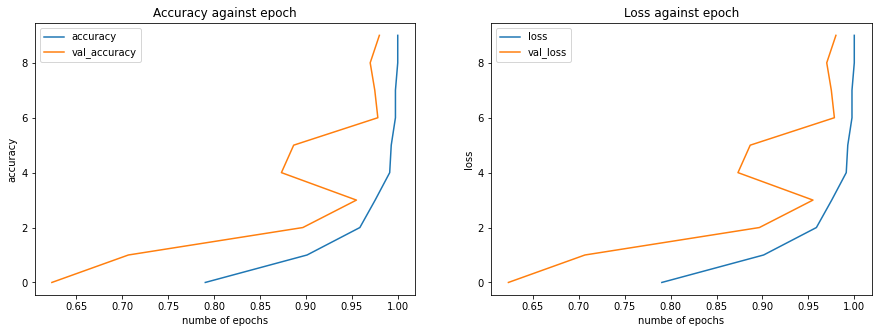

In [40]:
#Evaluate accuracy and loss against epochs
evaluate_model(history_5)

Waw now we have successfully been able to reduce our loss value to 0.006. We can see that our model is now performing very well. But we wont stop here we will try to performing more experiments and also try to intruduce transfere learning techniques going forward. Okay so without wasting much time, lets continue by building our 6th model.

## model_6
Alright so we are going to build our 6t model now. With this model, we are going to clone our 5th model but increase the total number of epochs to 20 hoping to reduce our loss value again. Okay so lets get started now.

In [41]:
#Set random seed
tf.random.set_seed(42)

#clone 5th model as 6th model
model_6 = tf.keras.models.clone_model(model_5)

#compile model
model_6.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [42]:
#Check model layer
model_6.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 100)       2800      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 100)       400       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 100)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        57664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0   

In [43]:
#Fit on traning datasets
history_6 = model_6.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20
)

Epoch 1/20
75/75 [==============================] - 3s 30ms/step - loss: 0.4444 - accuracy: 0.7900 - val_loss: 0.7929 - val_accuracy: 0.7117
Epoch 2/20
75/75 [==============================] - 2s 26ms/step - loss: 0.2747 - accuracy: 0.9071 - val_loss: 0.5923 - val_accuracy: 0.7150
Epoch 3/20
75/75 [==============================] - 2s 26ms/step - loss: 0.1766 - accuracy: 0.9583 - val_loss: 0.3362 - val_accuracy: 0.8467
Epoch 4/20
75/75 [==============================] - 2s 26ms/step - loss: 0.1191 - accuracy: 0.9754 - val_loss: 0.4780 - val_accuracy: 0.8050
Epoch 5/20
75/75 [==============================] - 2s 26ms/step - loss: 0.0733 - accuracy: 0.9887 - val_loss: 0.1176 - val_accuracy: 0.9733
Epoch 6/20
75/75 [==============================] - 2s 26ms/step - loss: 0.0595 - accuracy: 0.9925 - val_loss: 0.4881 - val_accuracy: 0.8000
Epoch 7/20
75/75 [==============================] - 2s 25ms/step - loss: 0.0335 - accuracy: 0.9967 - val_loss: 0.0912 - val_accuracy: 0.9750
Epoch 8/20
75

In [44]:
#Evaluate our model
loss_6, accuracy_6 = model_6.evaluate(x_test, y_test)
loss_6, accuracy_6

19/19 [==============================] - 0s 10ms/step - loss: 0.1189 - accuracy: 0.9700


(0.11894974112510681, 0.9700000286102295)

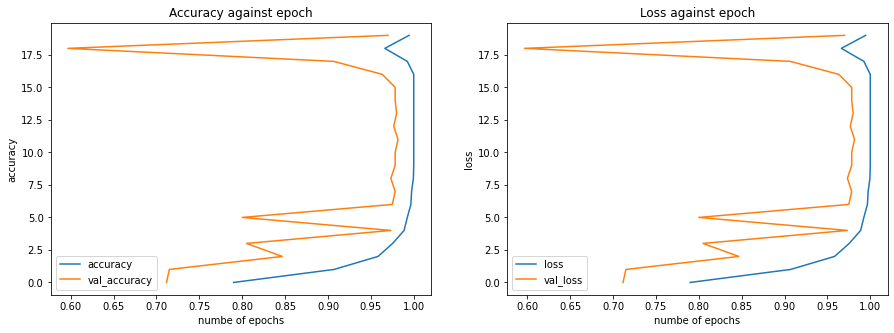

In [45]:
#Evaluate accuracy and loss against epoch
evaluate_model(history_6)

Greate now our model is doing much more better. Okay we we have successfully been able to reduce our loss value from 0.06 to 0.04. Now we are going to stop here. We will sop and compare the models we've built soo far and see the one which is performing well. Okay so now lets create a data frame out from our results.

In [46]:
#Create dataframe out of our loss and acuracy
df = pd.DataFrame({
 "val_loss": [loss_0, loss_1, loss_2, loss_3, loss_5, loss_6],
 "val_accuracy": [accuracy_0, accuracy_1, accuracy_2, accuracy_3, accuracy_5, accuracy_6]
}, index=["base model", "model_1", "model_2", "model_3", "model_5","model_6"])

In [47]:
#Display results
df

,val_loss,val_accuracy
base model,3.247375,0.946667
model_1,0.096323,0.975000
model_2,0.128644,0.961667
model_3,0.097741,0.970000
model_5,0.077698,0.980000
model_6,0.118950,0.970000


In [48]:
#sort results in ascending order
df_low = df.sort_values(by="val_loss", ascending=True)

#Display results
df_low

,val_loss,val_accuracy
model_5,0.077698,0.980000
model_1,0.096323,0.975000
model_3,0.097741,0.970000
model_6,0.118950,0.970000
model_2,0.128644,0.961667
base model,3.247375,0.946667


<Figure size 1440x720 with 0 Axes>

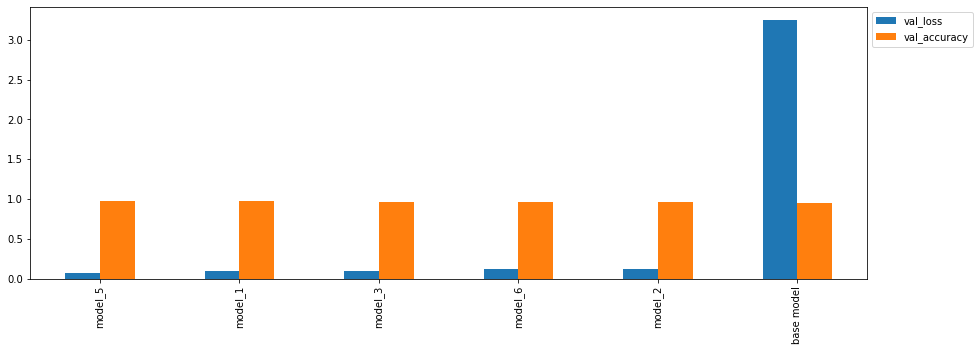

In [49]:
#Okay so lets visualize our results
plt.figure(figsize=(20, 10))
df_low.plot(kind="bar", figsize=(15, 5)).legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Testing 6th model
Okay so we are going to test our 6th model on test datasets and other datasets which the model has totally not seen before to see if its really performing well. Okay so before we do that, lets first create a custom function to preproccess our image and perform the prediction. Lets get started.

In [50]:
# a function to process and display images
def process_images(image_name, model):
  """
  this function will hel us to process
  a custoom image, visualize it and print
  its name attached to it.
  """
  image = cv2.imread(image_name)
  img = Image.fromarray(image)
  img=img.resize((64, 64))
  img=np.array(img)
  input_image = np.expand_dims(img, axis=0)
  res = model.predict(input_image)

  image_class = np.round(res[0][0])
  
  if image_class > 0.5:
    class_pred = "Tumor"
  else:
    class_pred = "No tumor"

  #Display image
  plt.imshow(img)
  plt.axis(False)
  plt.title(f"Predicted {class_pred} ({image_class})")

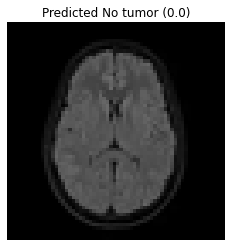

In [51]:
#Test models using predicted datasets
process_images("/content/brain_tumor_yes_no/pred/pred0.jpg", model_6)

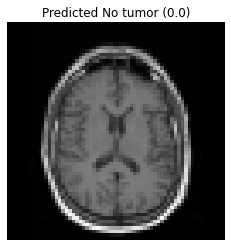

In [52]:
#Test models using predicted datasets
process_images("/content/brain_tumor_yes_no/pred/pred1.jpg", model_6)

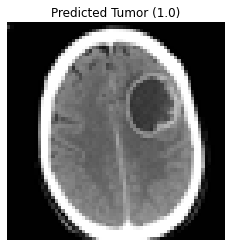

In [53]:
#Test models using predicted datasets
process_images("/content/brain_tumor_yes_no/pred/pred10.jpg", model_6)

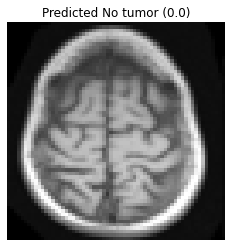

In [54]:
#Test models using predicted datasets
process_images("/content/brain_tumor_yes_no/pred/pred39.jpg", model_6)

# Save model
Okay so we are going to save our, import it and test it on our test datasets. Lets get started.

In [55]:
#save model
model_6.save("model_6.h5")

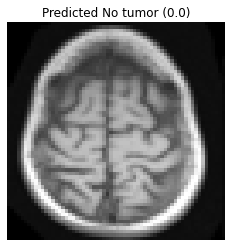

In [56]:
#Import model to test our testing datasets
model6 = tf.keras.models.load_model("model_6.h5")

#Test models using predicted datasets
process_images("/content/brain_tumor_yes_no/pred/pred39.jpg", model6)

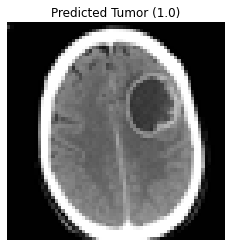

In [57]:
#Test models using predicted datasets
process_images("/content/brain_tumor_yes_no/pred/pred10.jpg", model6)

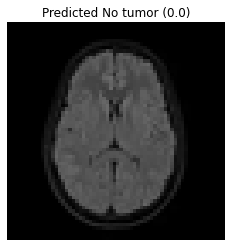

In [58]:
#Test models using predicted datasets
process_images("/content/brain_tumor_yes_no/pred/pred0.jpg", model6)